In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
import random
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/30-days-of-ml/sample_submission.csv
/kaggle/input/30-days-of-ml/train.csv
/kaggle/input/30-days-of-ml/test.csv


# **Data import**

In [2]:
train = pd.read_csv("/kaggle/input/30-days-of-ml/train.csv", low_memory=False)
test = pd.read_csv("/kaggle/input/30-days-of-ml/test.csv", low_memory=False)
train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

In [3]:
test.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      200000 non-null  int64  
 1   cat0    200000 non-null  object 
 2   cat1    200000 non-null  object 
 3   cat2    200000 non-null  object 
 4   cat3    200000 non-null  object 
 5   cat4    200000 non-null  object 
 6   cat5    200000 non-null  object 
 7   cat6    200000 non-null  object 
 8   cat7    200000 non-null  object 
 9   cat8    200000 non-null  object 
 10  cat9    200000 non-null  object 
 11  cont0   200000 non-null  float64
 12  cont1   200000 non-null  float64
 13  cont2   200000 non-null  float64
 14  cont3   200000 non-null  float64
 15  cont4   200000 non-null  float64
 16  cont5   200000 non-null  float64
 17  cont6   200000 non-null  float64
 18  cont7   200000 non-null  float64
 19  cont8   200000 non-null  float64
 20  cont9   200000 non-null  float64
 21  cont10  20

In [4]:
train.head(10)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260
5,7,A,B,A,C,B,D,A,E,G,...,0.392432,0.658169,0.997473,0.569874,0.960864,0.238050,0.316065,0.731729,0.694719,8.028558
6,8,B,A,A,A,B,D,A,E,C,...,0.396705,0.273454,0.824573,0.656325,0.677114,0.808445,0.615973,0.631677,0.283561,7.811465
7,9,A,A,A,C,B,B,A,E,A,...,0.633353,0.339760,0.802006,1.010997,0.391221,0.057297,0.591120,0.074629,0.775869,7.674188
8,10,A,B,A,C,B,D,A,E,G,...,0.472564,0.414036,0.809142,1.013301,0.761183,1.041711,0.393960,0.782381,0.865610,8.090095
9,11,A,A,A,A,B,B,A,E,E,...,0.425716,0.233705,0.493036,0.353048,0.334675,0.085087,0.230634,0.636732,0.291874,8.446155


# **EDA**

In [5]:
# Colors to be used for plots
colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]

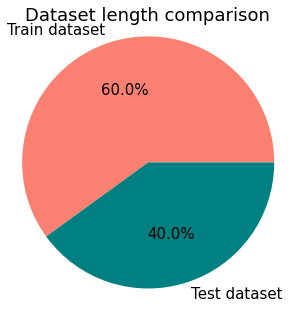

In [6]:
# Comparing the datasets length
fig, ax = plt.subplots(figsize=(5, 5))
pie = ax.pie([len(train), len(test)],
             labels=["Train dataset", "Test dataset"],
             colors=["salmon", "teal"],
             textprops={"fontsize": 15},
             autopct='%1.1f%%')
ax.axis("equal")
ax.set_title("Dataset length comparison", fontsize=18)
fig.set_facecolor('white')
plt.show();

In [7]:
# Statistical description of the train dataset
train.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
id,300000.0,250018.576947,144450.150010,1.000000,49932.900000,124772.500000,250002.500000,375226.500000,450149.100000,499999.000000
cont0,300000.0,0.527335,0.230599,-0.118039,0.254242,0.405965,0.497053,0.668060,0.871943,1.058443
cont1,300000.0,0.460926,0.214003,-0.069309,0.242940,0.310494,0.427903,0.615113,0.789630,0.887253
cont2,300000.0,0.490498,0.253346,-0.056104,0.182464,0.300604,0.502462,0.647512,0.848327,1.034704
cont3,300000.0,0.496689,0.219199,0.130676,0.219944,0.329783,0.465026,0.664451,0.796854,1.039560
cont4,300000.0,0.491654,0.240074,0.255908,0.276352,0.284188,0.390470,0.696599,0.876275,1.055424
cont5,300000.0,0.510526,0.228232,0.045915,0.251022,0.354141,0.488865,0.669625,0.828467,1.067649
cont6,300000.0,0.467476,0.210331,-0.224689,0.245036,0.342873,0.429383,0.573383,0.766758,1.111552
cont7,300000.0,0.537119,0.218140,0.203763,0.284645,0.355825,0.504661,0.703441,0.868613,1.032837
cont8,300000.0,0.498456,0.239920,-0.260275,0.264466,0.332486,0.439151,0.606056,0.909264,1.040229


In [8]:
# Checking if there are missing values in the datasets
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

There are no missing value in the both datasets.

Let's check target distribution.

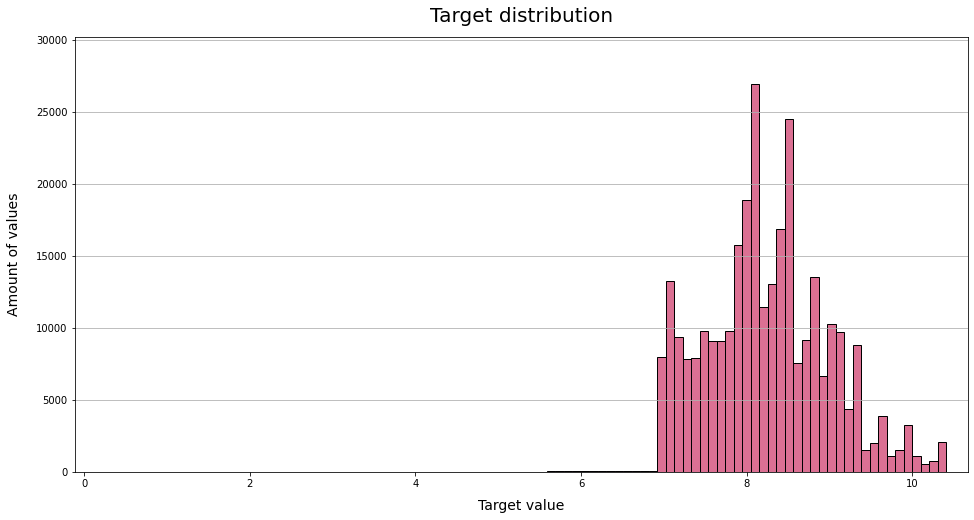

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))

bars = ax.hist(train["target"],
               bins=100,
               color="palevioletred",
               edgecolor="black")
ax.set_title("Target distribution", fontsize=20, pad=15)
ax.set_ylabel("Amount of values", fontsize=14, labelpad=15)
ax.set_xlabel("Target value", fontsize=14, labelpad=10)
ax.margins(0.025, 0.12)
ax.grid(axis="y")

plt.show();

In [10]:
print(f"{(train['target'] < 5).sum() / len(train) * 100:.3f}% of the target values are less than 5")

0.059% of the target values are less than 5


The dataset contains categorical and numerical values. Let's see values distribution for these categories.

In [11]:
# Lists of categorical and numerical feature columns
cat_features = ["cat" + str(i) for i in range(10)]
num_features = ["cont" + str(i) for i in range(14)]

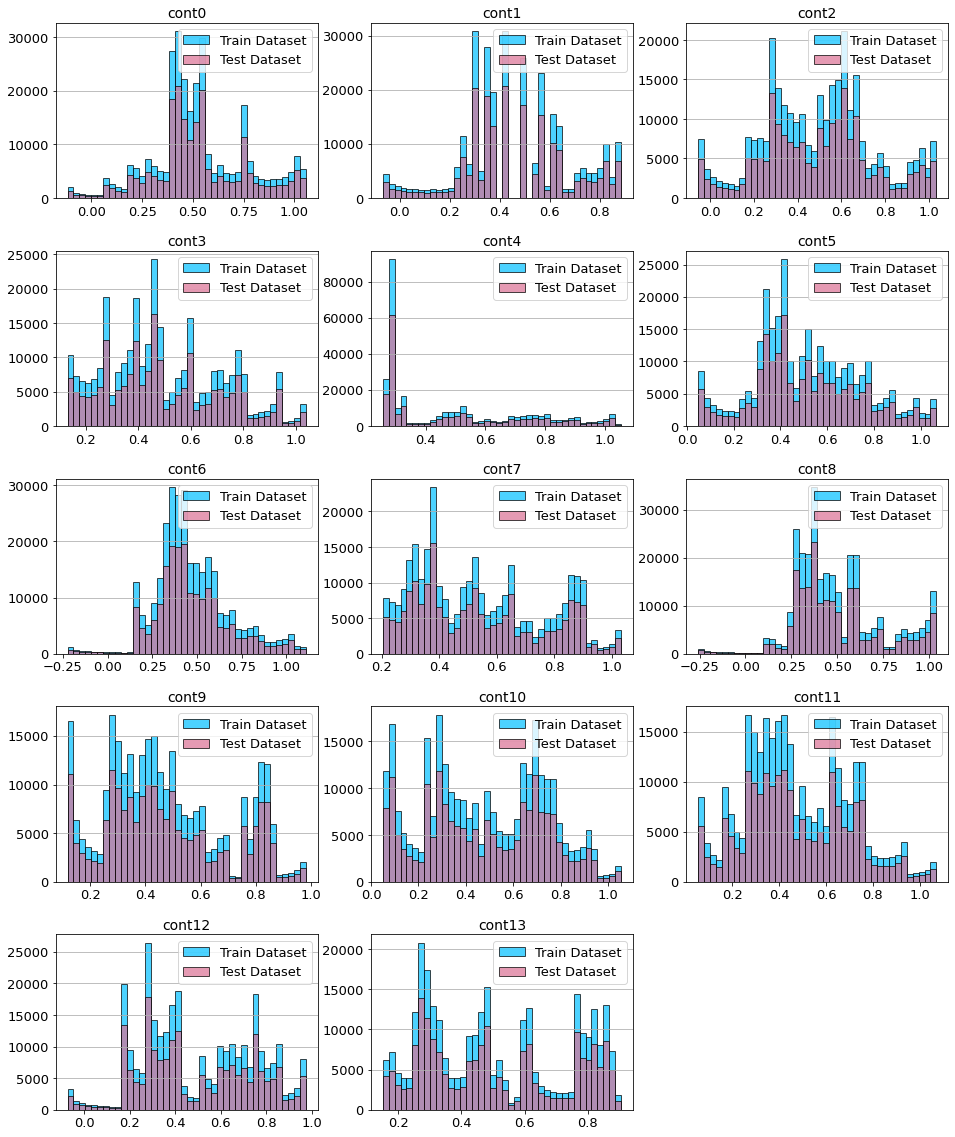

In [12]:
# Combined dataframe containing numerical features only
df = pd.concat([train[num_features], test[num_features]], axis=0)
columns = df.columns.values

# Calculating required amount of rows to display all feature plots
cols = 3
rows = len(columns) // cols + 1

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16,20), sharex=False)

# Adding some distance between plots
plt.subplots_adjust(hspace = 0.3)

# Plots counter
i=0
for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(columns): # If there is no more data columns to make plots from
            axs[r, c].set_visible(False) # Hiding axes so there will be clean background
        else:
            # Train data histogram
            hist1 = axs[r, c].hist(train[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   bins=40,
                                   color="deepskyblue",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Train Dataset")
            # Test data histogram
            hist2 = axs[r, c].hist(test[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   bins=40,
                                   color="palevioletred",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Test Dataset")
            axs[r, c].set_title(columns[i], fontsize=14, pad=5)
            axs[r, c].tick_params(axis="y", labelsize=13)
            axs[r, c].tick_params(axis="x", labelsize=13)
            axs[r, c].grid(axis="y")
            axs[r, c].legend(fontsize=13)
                                  
        i+=1
# plt.suptitle("Numerical feature values distribution in both datasets", y=0.99)
plt.show();

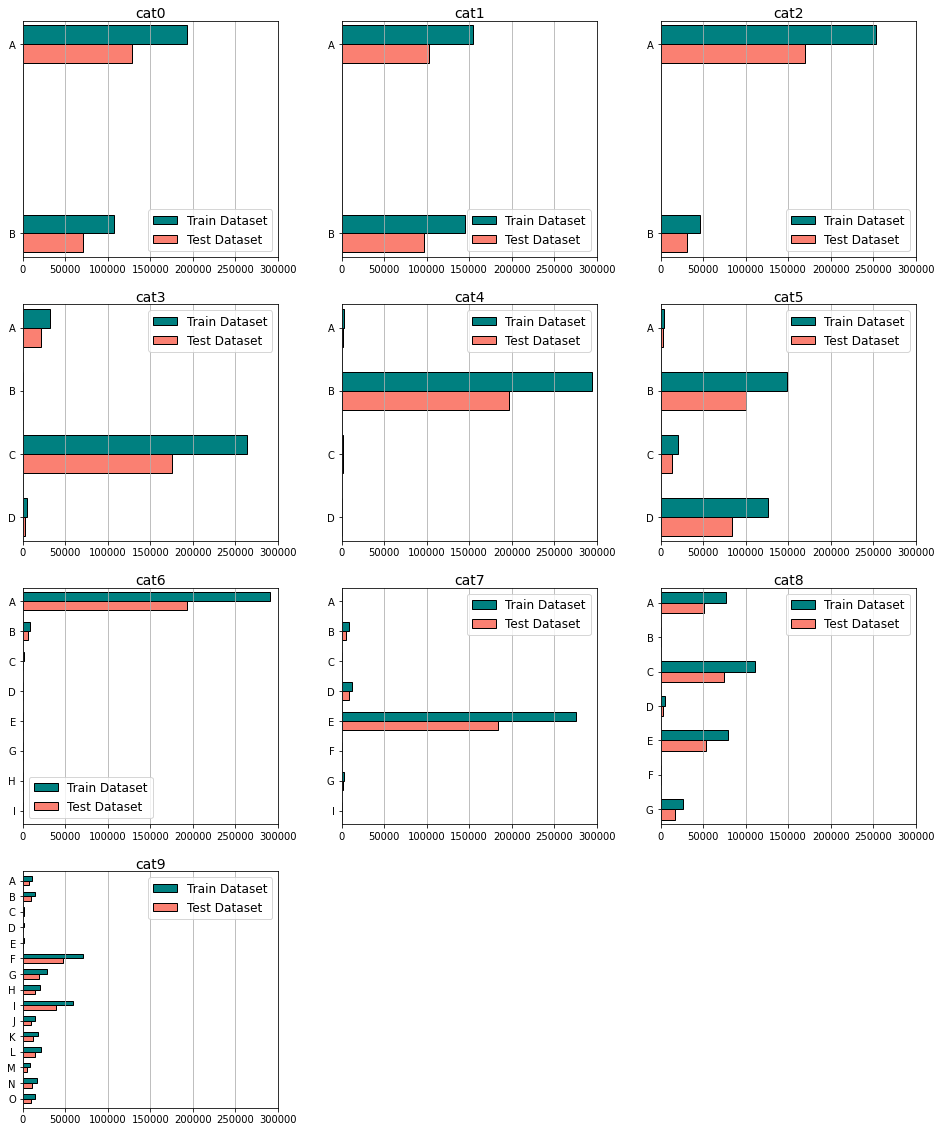

In [13]:
# Combined dataframe containing categorical features only
df = pd.concat([train[cat_features], test[cat_features]], axis=0)
columns = df.columns.values

# Calculating required amount of rows to display all feature plots
cols = 3
rows = len(columns) // cols + 1

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16,20), sharex=False)

# Adding some distance between plots
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

# Plots counter
i=0
for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(cat_features): # If there is no more data columns to make plots from
            axs[r, c].set_visible(False) # Hiding axes so there will be clean background
        else:

            values = df[cat_features[i]].value_counts().sort_index(ascending=False).index
            bars_pos = np.arange(0, len(values))
            if len(values)<4:
                height=0.1
            else:
                height=0.3

            bars1 = axs[r, c].barh(bars_pos+height/2,
                                   [train[train[cat_features[i]]==x][cat_features[i]].count() for x in values],
                                   height=height,
                                   color="teal",
                                   edgecolor="black",
                                   label="Train Dataset")
            bars2 = axs[r, c].barh(bars_pos-height/2,
                                   [test[test[cat_features[i]]==x][cat_features[i]].count() for x in values],
                                   height=height,
                                   color="salmon",
                                   edgecolor="black",
                                   label="Test Dataset")
            y_labels = [str(x) for x in values]

            axs[r, c].set_title(cat_features[i], fontsize=14, pad=1)
            axs[r, c].set_xlim(0, len(train["id"])+50)
            axs[r, c].set_yticks(bars_pos)
            axs[r, c].set_yticklabels(y_labels)
            axs[r, c].tick_params(axis="y", labelsize=10)
            axs[r, c].tick_params(axis="x", labelsize=10)
            axs[r, c].grid(axis="x")
            axs[r, c].legend(fontsize=12)
            axs[r, c].margins(0.1, 0.02)
                                  
        i+=1

#plt.suptitle("Categorical feature values distribution in both datasets", y=0.99)
plt.show();

Let's check if the datasets have different amount of categories in categorical features.

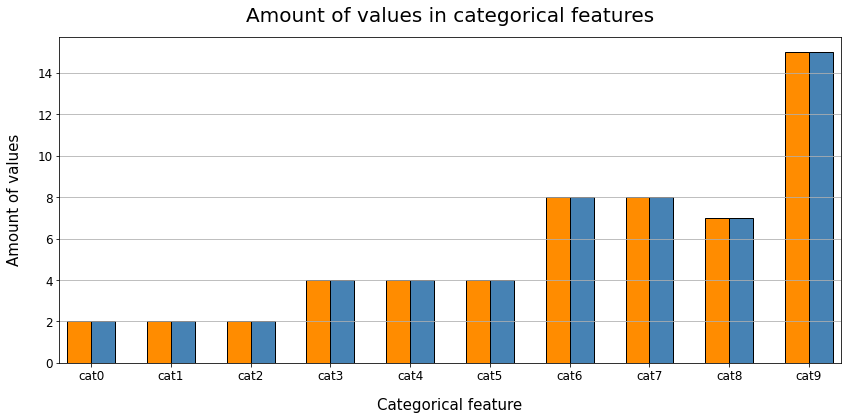

In [14]:
# Bars position should be numerical because there will be arithmetical operations with them
bars_pos = np.arange(len(cat_features))

width=0.3
fig, ax = plt.subplots(figsize=(14, 6))
# Making two bar objects. One is on the left from bar position and the other one is on the right
bars1 = ax.bar(bars_pos-width/2,
               train[cat_features].nunique().values,
               width=width,
               color="darkorange", edgecolor="black")
bars2 = ax.bar(bars_pos+width/2,
               train[cat_features].nunique().values,
               width=width,
               color="steelblue", edgecolor="black")
ax.set_title("Amount of values in categorical features", fontsize=20, pad=15)
ax.set_xlabel("Categorical feature", fontsize=15, labelpad=15)
ax.set_ylabel("Amount of values", fontsize=15, labelpad=15)
ax.set_xticks(bars_pos)
ax.set_xticklabels(cat_features, fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(axis="y")
plt.margins(0.01, 0.05)

In [15]:
# Checking if test data doesn't contain categories that are not present in the train dataset
for col in cat_features:
    print(set(train[col].value_counts().index) == set(test[col].value_counts().index))

True
True
True
True
True
True
True
True
True
True


So the datasets are pretty well balanced. Let's look at feature correlation.

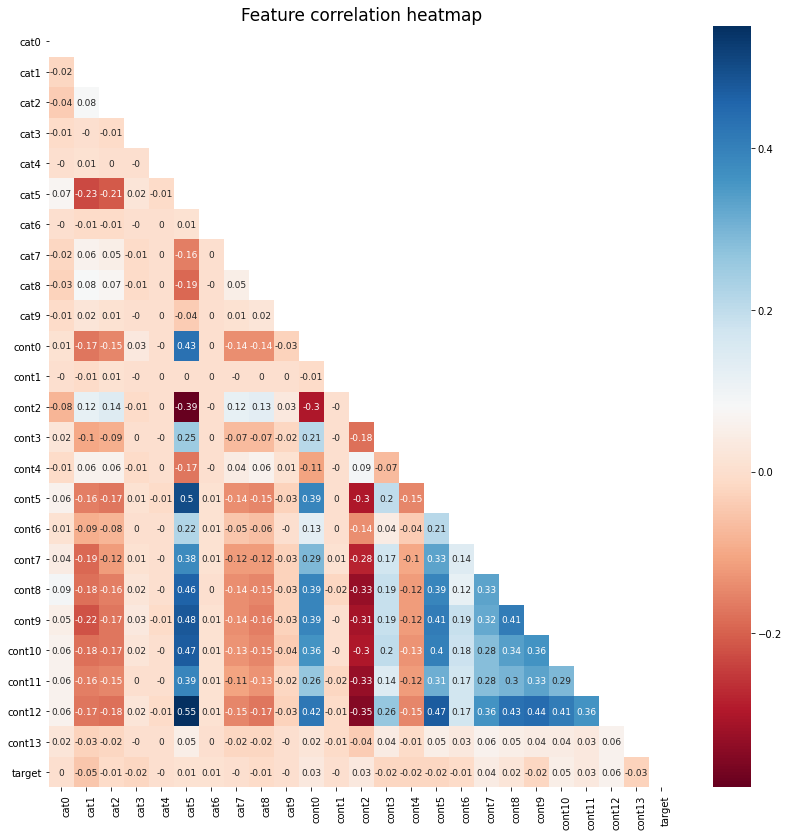

In [16]:
# Plot dataframe
df = train.drop("id", axis=1)

# Encoding categorical features with OrdinalEncoder
for col in cat_features:
    encoder = OrdinalEncoder()
    df[col] = encoder.fit_transform(np.array(df[col]).reshape(-1, 1))

# Calculatin correlation values
df = df.corr().round(2)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(14,14))
ax = sns.heatmap(df, annot=True, mask=mask, cmap="RdBu", annot_kws={"weight": "normal", "fontsize":9})
ax.set_title("Feature correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", weight="normal")
plt.setp(ax.get_yticklabels(), weight="normal",
         rotation_mode="anchor", rotation=0, ha="right")
plt.show();

As you can see, target column is very weakly correlated with all features.

Let's visualize each feature vs target.

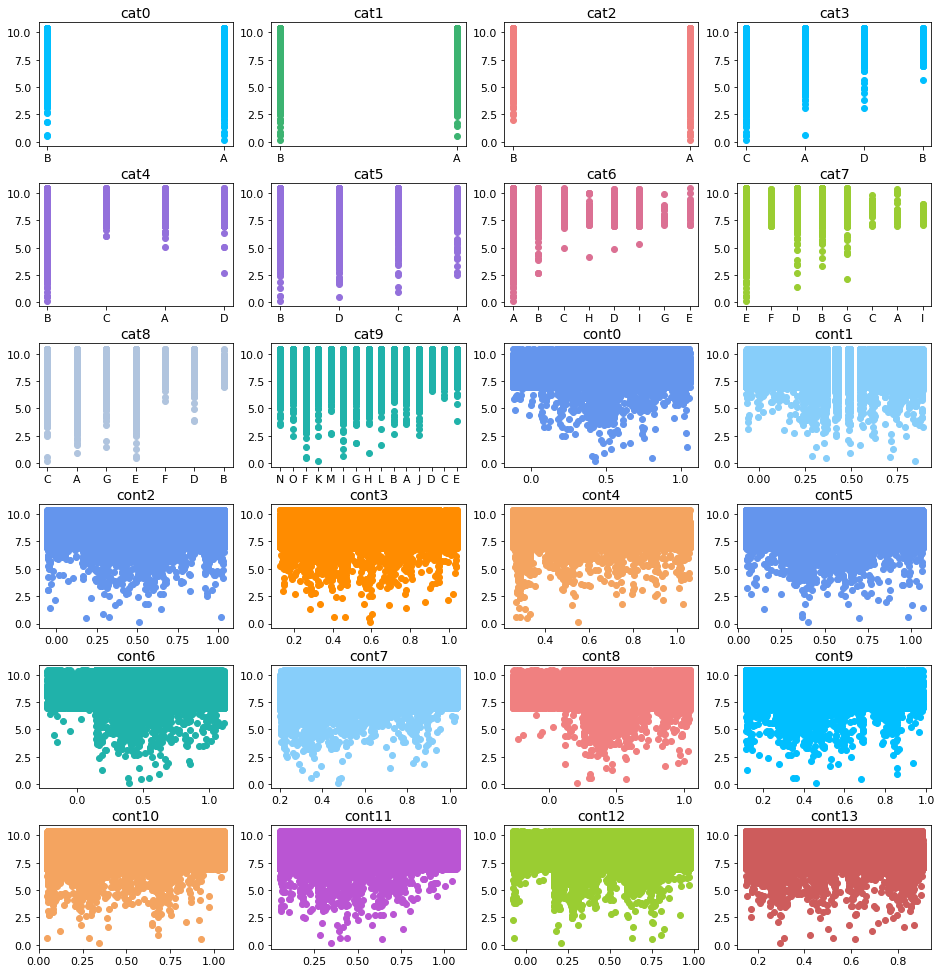

In [17]:
columns = train.drop(["id", "target"], axis=1).columns.values

# Calculating required amount of rows to display all feature plots
cols = 4
rows = len(columns) // cols + 1

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16,20), sharex=False)

# Adding some distance between plots
plt.subplots_adjust(hspace = 0.3)

i=0
for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(columns):
            axs[r, c].set_visible(False)
        else:
            scatter = axs[r, c].scatter(train[columns[i]].values,
                                        train["target"],
                                        color=random.choice(colors))
            axs[r, c].set_title(columns[i], fontsize=14, pad=5)
            axs[r, c].tick_params(axis="y", labelsize=11)
            axs[r, c].tick_params(axis="x", labelsize=11)
                                  
        i+=1
# plt.suptitle("Features vs target", y=0.99)
plt.show();

# **Data preprocessing**

In [18]:
# Encoding categorical features with OrdinalEncoder
for col in cat_features:
    encoder = OrdinalEncoder()
    train[col] = encoder.fit_transform(np.array(train[col]).reshape(-1, 1))
    test[col] = encoder.transform(np.array(test[col]).reshape(-1, 1))

In [19]:
train[cat_features].head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0


In [20]:
test[cat_features].head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,4.0,8.0
1,0.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,2.0,7.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,3.0,10.0
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0
4,1.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,2.0,5.0


In [21]:
X = train.drop(["id", "target"], axis=1)
X_test = test.drop(["id"], axis=1)
y = train["target"]

# **Model training**

In [22]:
# Model hyperparameters
xgb_params = {'n_estimators': 10000,
              'learning_rate': 0.35,
              'subsample': 0.926,
              'colsample_bytree': 0.84,
              'max_depth': 2,
              'booster': 'gbtree', 
              'reg_lambda': 35.1,
              'reg_alpha': 34.9,
              'random_state': 42,
              'n_jobs': 4}

In [23]:
%%time
# Setting up fold parameters
splits = 10
skf = KFold(n_splits=splits, shuffle=True, random_state=42)

# Creating an array of zeros for storing "out of fold" predictions
oof_preds = np.zeros((X.shape[0],))
preds = 0
model_fi = 0
total_mean_rmse = 0

# Generating folds and making training and prediction for each of 10 folds
for num, (train_idx, valid_idx) in enumerate(skf.split(X)):
    X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
    
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train,
              verbose=False,
              # These three parameters will stop training before a model starts overfitting 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric="rmse",
              early_stopping_rounds=100,
              )
    
    # Getting mean test data predictions (i.e. devided by number of splits)
    preds += model.predict(X_test) / splits
    
    # Getting mean feature importances (i.e. devided by number of splits)
    model_fi += model.feature_importances_ / splits
    
    # Getting validation data predictions. Each fold model makes predictions on an unseen data.
    # So in the end it will be completely filled with unseen data predictions.
    # It will be used to evaluate hyperparameters performance only.
    oof_preds[valid_idx] = model.predict(X_valid)
    
    # Getting score for a fold model
    fold_rmse = np.sqrt(mean_squared_error(y_valid, oof_preds[valid_idx]))
    print(f"Fold {num} RMSE: {fold_rmse}")

    # Getting mean score of all fold models (i.e. devided by number of splits)
    total_mean_rmse += fold_rmse / splits
    
print(f"\nOverall RMSE: {total_mean_rmse}")

Fold 0 RMSE: 0.7163854154224646
Fold 1 RMSE: 0.7158896832444135
Fold 2 RMSE: 0.7153804635304541
Fold 3 RMSE: 0.7174273397030418
Fold 4 RMSE: 0.7217814193439362
Fold 5 RMSE: 0.715080804888367
Fold 6 RMSE: 0.7174236758448709
Fold 7 RMSE: 0.7187316249002862
Fold 8 RMSE: 0.7199913801706614
Fold 9 RMSE: 0.7126560044288408

Overall RMSE: 0.7170747811477337
CPU times: user 2h 11min 31s, sys: 5.07 s, total: 2h 11min 36s
Wall time: 33min 23s


# **Feature importances**

In [24]:
# Creating a dataframe to be used for plotting
df = pd.DataFrame()
df["Feature"] = X.columns
# Extracting feature importances from the trained model
df["Importance"] = model_fi / model_fi.sum()
# Sorting the dataframe by feature importance
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

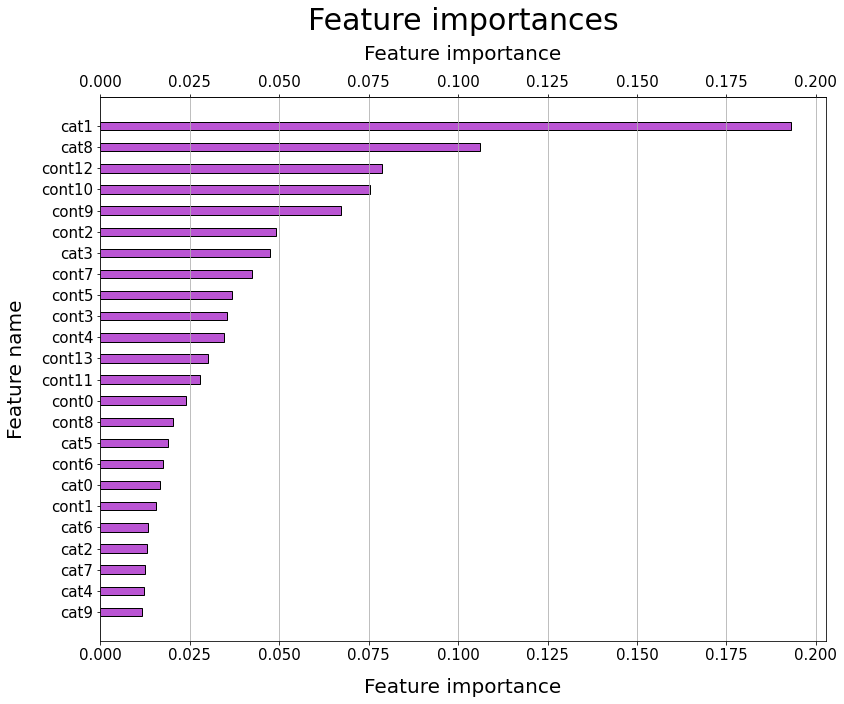

In [25]:
fig, ax = plt.subplots(figsize=(13, 10))
bars = ax.barh(df["Feature"], df["Importance"], height=0.4,
               color="mediumorchid", edgecolor="black")
ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature name", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(df["Feature"])
ax.set_yticklabels(df["Feature"], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
# Adding labels on top
ax2 = ax.secondary_xaxis('top')
ax2.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax2.tick_params(axis="x", labelsize=15)

# Inverting y axis direction so the values are decreasing
plt.gca().invert_yaxis()

# **Predictions submission**

In [26]:
predictions = pd.DataFrame()
predictions["id"] = test["id"]
predictions["target"] = preds

predictions.to_csv('submission.csv', index=False, header=predictions.columns)
predictions.head()

,id,target
0,0,8.080814
1,5,8.386310
2,15,8.381057
3,16,8.496331
4,17,8.140758
